# Forecast Model with Prophet

MVP pipeline for Prohpet
 

In [61]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')


from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline


from statsmodels.graphics.gofplots import qqplot

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

from model_persistence import get_persistence_dataset, train_test_split, calculate_errors, plot_error

from create_day_types import get_days_dummies

In [4]:
#load the persistence dataset
data = pd.read_csv('../dataset/Amity-OR.csv')

In [5]:
#leave 2023 as a hold out test set
def train_test_split(data, split_date='2022-11-01'):
    train = data.loc[data['date'] < split_date].copy()
    test = data.loc[data['date'] >= split_date].copy()
    return train, test
train, test = train_test_split(data)

In [6]:
print('Train date start: ', train.date.min())
print('Train date end: ', train.date.max())
print('length of train: ', len(train), f' ({len(train) / len(data) * 100:.2f}%)')
print('-------------------')
print('Test date start: ', test.date.min())
print('Test date end: ', test.date.max())
print('length of test: ', len(test), f' ({len(test) / len(data) * 100:.2f}%)')


Train date start:  2022-01-01 08:00:00
Train date end:  2022-10-31 23:00:00
length of train:  7288  (83.20%)
-------------------
Test date start:  2022-11-01 00:00:00
Test date end:  2023-01-01 07:00:00
length of test:  1472  (16.80%)


In [7]:
train.head()

,date,value
0,2022-01-01 08:00:00,0.678119
1,2022-01-01 09:00:00,0.661744
2,2022-01-01 10:00:00,0.667333
3,2022-01-01 11:00:00,0.683100
4,2022-01-01 12:00:00,0.717013


In [8]:
def prep_for_prophet(data, index= 'date', target_col='value'):

    #set datetime index as a column in the dataframe
    # data = data.reset_index()

    #convert the datetime column to a datetime object
    data[index] = pd.to_datetime(data[index])

    #select out the datetime and target columns
    data[['ds', 'y']] = data[[index, target_col]]

    #drop unneeded columns
    data.drop([index, target_col], axis=1, inplace=True)
    
    #now that the datetime index is gone be double sure our data is ordered correctly.
    data.sort_values(by=['ds'], inplace=True)
    
    return data

In [9]:
#reformat columns for training data 
train = prep_for_prophet(train)

#reformt columns for test data with no y values
test = prep_for_prophet(test)


train.head()

,ds,y
0,2022-01-01 08:00:00,0.678119
1,2022-01-01 09:00:00,0.661744
2,2022-01-01 10:00:00,0.667333
3,2022-01-01 11:00:00,0.683100
4,2022-01-01 12:00:00,0.717013


### Univariate Model

Using only the properties of the time series itself and seasonality at daily, weekly, and yearly scales. 

##### Setup the basic version of the model

In [10]:
#first attempt at using prophet
base_model = Prophet()
base_model.fit(train)

14:48:55 - cmdstanpy - INFO - Chain [1] start processing
14:48:57 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
#make the future dataframe. a df of 30 days with hourly intervals
test_dates = base_model.make_future_dataframe(periods=len(test), freq='H')

##### Make the base case forecast

In [12]:
forecast_base_model = base_model.predict(test_dates)

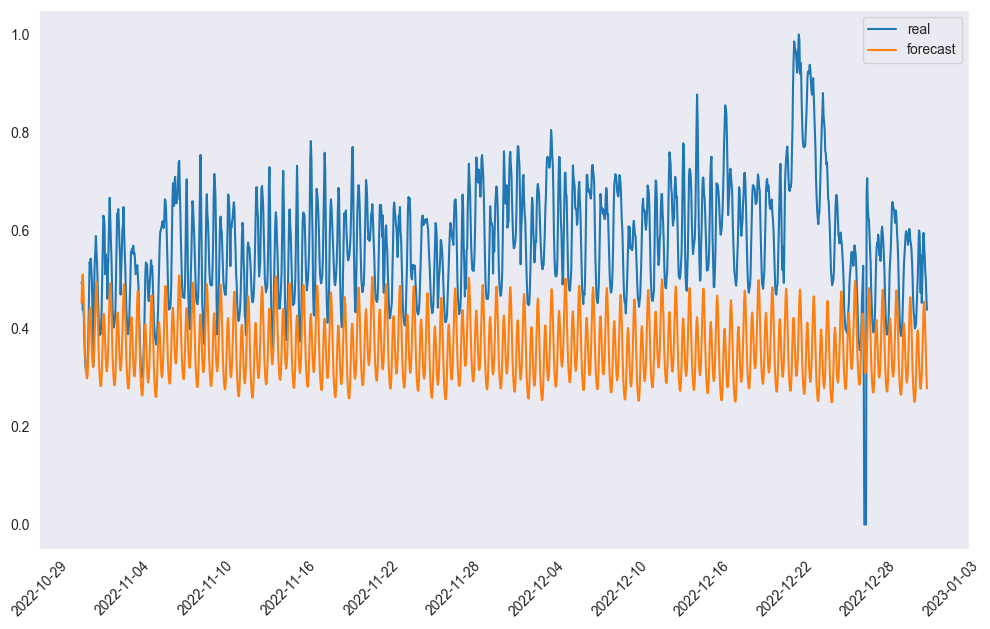

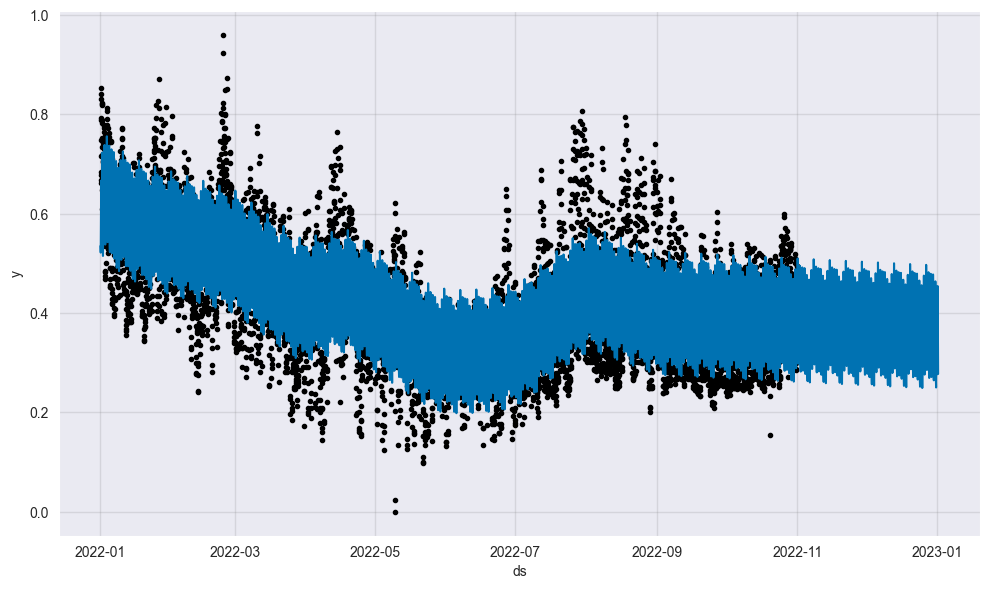

In [15]:
base_model_results = forecast_base_model.iloc[-len(test):]

#inspect the forecast vs the real values
fig = plt.figure(figsize=(12,7))

plt.plot(test['ds'], test['y'])
plt.plot(base_model_results['ds'], base_model_results['yhat'])

# show legend
plt.legend(['real', 'forecast'])

#rotate the x axis labels
plt.xticks(rotation=45)

#set the x axis to show every 7th label
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))


fig1 = base_model.plot(forecast_base_model, uncertainty=False)

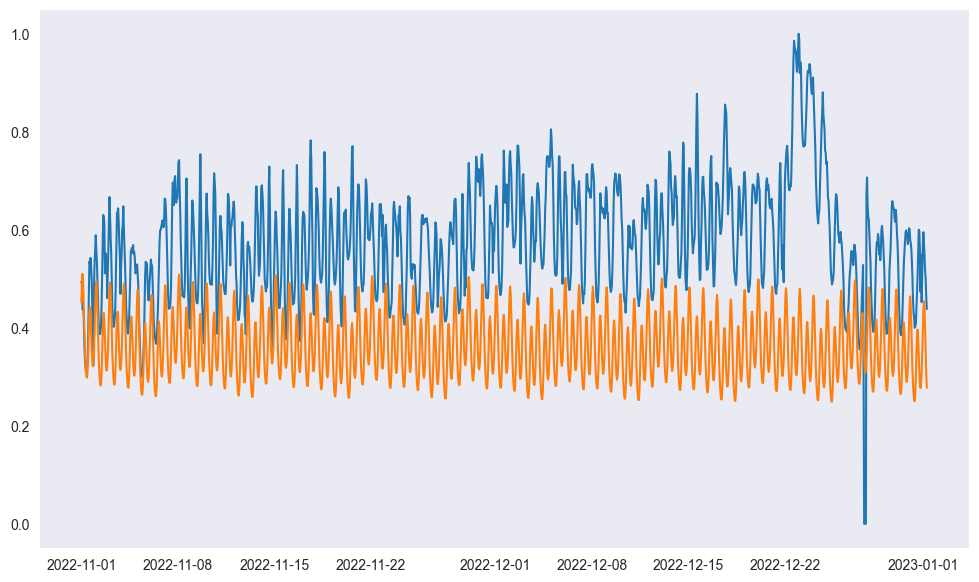

In [16]:
base_model_results = forecast_base_model.iloc[-len(test):]

#inspect the forecast vs the real values
fig = plt.figure(figsize=(12,7))

plt.plot(test['ds'], test['y'])
plt.plot(base_model_results['ds'], base_model_results['yhat'])

#fig1 = base_model.plot(forecast_base_model, uncertainty=False)

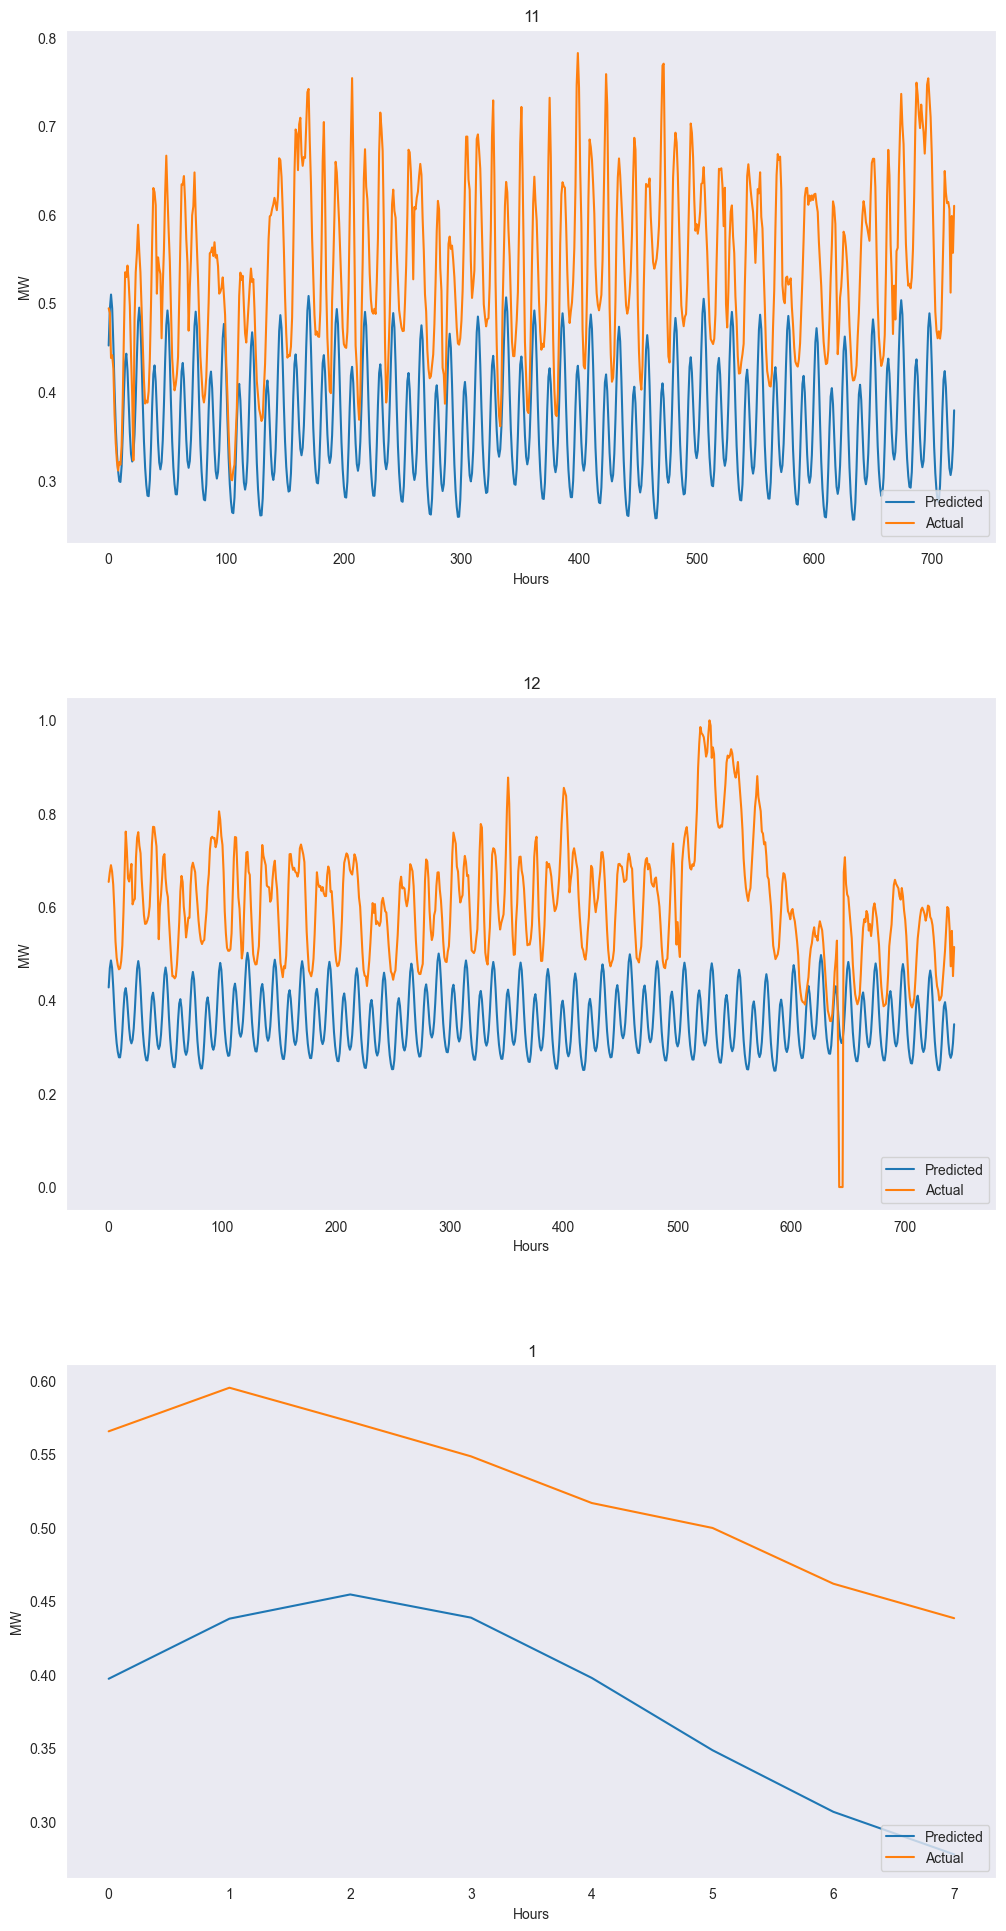

In [46]:
## plot in monthly segments and inspect the data
fig, axs = plt.subplots(3,1, figsize=(12,24))


datetimes = pd.to_datetime(test['ds'])
actual = test.set_index(pd.DatetimeIndex(datetimes))
predicted_base = base_model_results.set_index(pd.DatetimeIndex(datetimes))

actual_groups = actual['y'].groupby(pd.Grouper(freq='M'))
predicted_base_groups = predicted_base['yhat'].groupby(pd.Grouper(freq='M'))

for ax, (name, act), (_, pred) in zip(axs, actual_groups, predicted_base_groups):
    
    #plot the data
    ax.plot(pd.Series(pred.values), label='Predicted')
    ax.plot(pd.Series(act.values), label='Actual')
    ax.set_title(name.month)
    ax.legend(loc='lower right')
    ax.set_xlabel('Hours')
    ax.set_ylabel('MW')
plt.subplots_adjust(hspace=0.3)
    

In [39]:
train.iloc[606]

ds    2022-01-26 14:00:00
y                 0.82683
Name: 606, dtype: object

COMMENTS ON HOW FORECAST LOOKS

##### Cross validation of the base_model

Prophet cross validator (expanding window) works on the training set.

inital size of the train set is 30648 hours ~1277 days. Use cross validator on the last 6 months of the training data. Therefore:
- inital size: 3 yrs * 30 days * 24 hours ~ 26304. this leaves 29 periods to make the corss validation sequence.
- period is the frequency that a prediction is made. In this case we make a prediction every day at midnight for the next 24 hours.
- horizon is how far in the future should we predict. In this case we are predicting the next 24 hourly time steps.

In [40]:
train.iloc[606]

ds    2022-01-26 14:00:00
y                 0.82683
Name: 606, dtype: object

In [ ]:
#run cross validation on the forecast. expanding window per day of the week's forecast

#inital is the size of the training data 31 days * 24 hours = 744 hours
#period is the frequency to make a precition. in this case every day, so every 24 hours
#horizon is the distance in the future to make a prediction. 1 week * 24 hours = 168 hours

cv_base_model = cross_validation(base_model, initial=f'{int(len(train)/24)} hours', period='24 hours', horizon='24 hours')

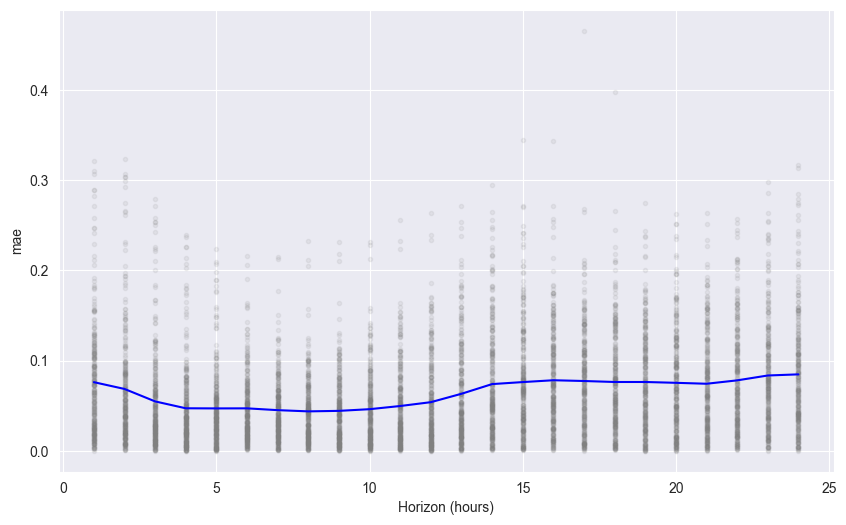

In [65]:
#plot the hourly mean absolute error across all the cross validation examples. 
base_model_cv_fig = plot_cross_validation_metric(cv_base_model, metric='mae', rolling_window=0)

In [66]:
#print out the models performance metrics
cv_base_model_metrics = performance_metrics(cv_base_model)

print('Base model MAE {0:.2f}' .format(np.mean(cv_base_model_metrics['mae'])))

cv_base_model_metrics

Base model MAE 0.06


,horizon,mse,rmse,mae,mdape,smape,coverage
0,0 days 03:00:00,0.007714,0.087830,0.064026,0.096414,0.127005,0.766673
1,0 days 04:00:00,0.005720,0.075632,0.053837,0.081517,0.103575,0.826214
2,0 days 05:00:00,0.004438,0.066618,0.048303,0.078580,0.096233,0.859988
3,0 days 06:00:00,0.003878,0.062271,0.047007,0.081483,0.102508,0.866270
4,0 days 07:00:00,0.003504,0.059195,0.046176,0.094385,0.112337,0.879154
5,0 days 08:00:00,0.003253,0.057035,0.044790,0.103096,0.120062,0.894923
6,0 days 09:00:00,0.003234,0.056872,0.044127,0.109004,0.126816,0.898911
7,0 days 10:00:00,0.003453,0.058765,0.044914,0.119223,0.134285,0.883723
8,0 days 11:00:00,0.003916,0.062577,0.047252,0.120318,0.142858,0.859087
9,0 days 12:00:00,0.004625,0.068005,0.050804,0.128158,0.149625,0.821567


##### Prediction analysis

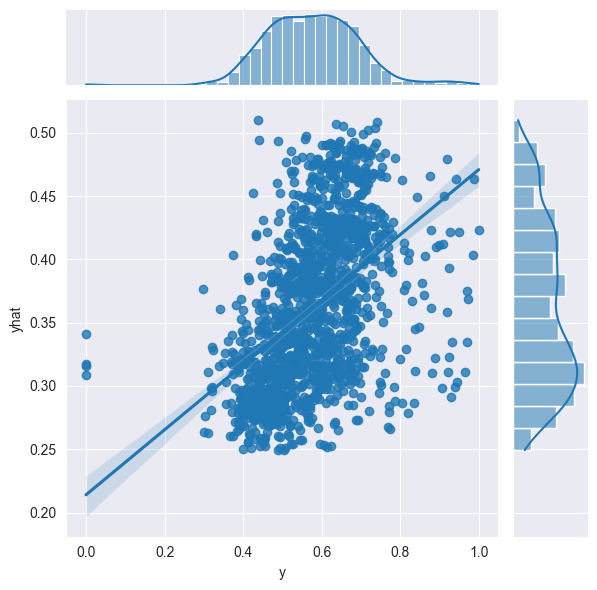

In [67]:
# joint plot of predictions
joint_df = pd.concat([test['y'], base_model_results['yhat']], axis=1)
sns.jointplot(joint_df, x='y', y='yhat', kind='reg')

In [63]:
#align the indexes on the test and forecast series objects
test = test.set_index(forecast_base_model.iloc[-len(test):, -1].index)
test['y'].index, forecast_base_model.iloc[-len(test):, -1].index

(RangeIndex(start=7288, stop=8760, step=1),
 RangeIndex(start=7288, stop=8760, step=1))

Text(0.5, 1.0, 'Autocorrelation of residuals')

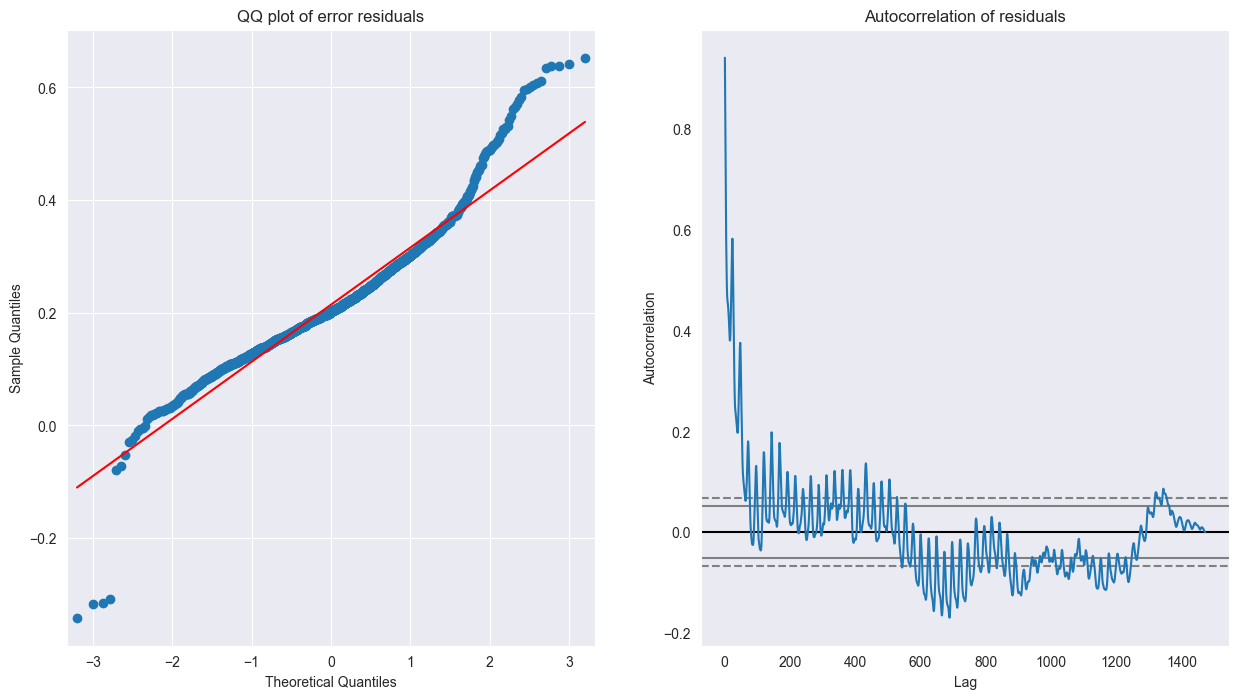

In [68]:
##### residuals analysis
#calcualte the residuals
residuals_base_model = test['y'] - forecast_base_model.iloc[-len(test):, -1]

#set the plot figure and axis
fig, axs = plt.subplots(1,2, figsize=(15,8))

#calcualte the qq plot
qqplot(residuals_base_model, line='r', ax=axs[0]);
axs[0].set_title('QQ plot of error residuals')

#calcualte the autocorelation plot
pd.plotting.autocorrelation_plot(residuals_base_model, ax=axs[1])
axs[1].set_title('Autocorrelation of residuals')


## Model 2: Using Day Names & Holidays

### Adding Holiday and day of the week regressors

Holidays we can use the add_country_holidays() built in feature from Prophet to add holiday features.

To add extra days we will generate a list of numberd day names per calender date. This is then added as an extra regressor to the prophet model. 

##### Generate days of the week dataframe

In [137]:
#create a set of dummiy variables for the days of the week. 
#use one day ahead on the stop date so that the indexes align
days_df = get_days_dummies(start='2018-01-01', stop='2018-04-01', frequency='H')

days_df.tail(3)

,mon,tue,wed,thur,fri,sat,sun
2018-03-31 22:00:00,0,0,0,0,0,1,0
2018-03-31 23:00:00,0,0,0,0,0,1,0
2018-04-01 00:00:00,0,0,0,0,0,0,1


##### Construct the dataset containing the target and the regressors

In [138]:
#setup our data for the model.
data = get_persistence_dataset(index='time', start='2018-01-01', stop='2018-03-31', shift=0)

#add the day of the week regressors.
#drop the last row which contains a NAN
data = pd.concat([data, days_df], axis=1).dropna()

#split in train and test
train, test = train_test_split(data, split_date='2018-02-28')

#reformat columns for training data 
train = prep_for_prophet(train)

#reformt columns for test data with no y values
test = prep_for_prophet(test)


print('Length of the train dataset {}' .format(len(train)))
print('Length of the test dataset {}' .format(len(test)))
train.head(3)

Length of the train dataset 1416
Length of the test dataset 744


,mon,tue,wed,thur,fri,sat,sun,ds,y
0,1,0,0,0,0,0,0,2018-01-01 00:00:00,22779.0
1,1,0,0,0,0,0,0,2018-01-01 01:00:00,22009.0
2,1,0,0,0,0,0,0,2018-01-01 02:00:00,20589.0


##### Initalize the holiday model instance.

Manually set the prior of the holiday factor.

Add a regressor for each of the days monday through sunday.

In [146]:
#holiday model initalize
holiday_model = Prophet(yearly_seasonality=False, 
                        seasonality_mode='additive',
                        holidays_prior_scale=35)

#add holidays for spain
holiday_model.add_country_holidays(country_name='ES')

#train the model
holiday_model.fit(train)

/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [126]:
#a look at the holidays included in the prediction
holiday_model.train_holiday_names

0                          Año nuevo
1                 Epifanía del Señor
2                      Viernes Santo
3                 Día del Trabajador
4              Asunción de la Virgen
5               Día de la Hispanidad
6                   Todos los Santos
7    Día de la constitución Española
8           La Inmaculada Concepción
9                            Navidad
dtype: object

##### Generate the future deates for predictions

In [140]:
#generate the forecasting dates/hours
test_dates = holiday_model.make_future_dataframe(periods=len(test), freq='H')

day_regressor_cols = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun']

#recreate the original data df and add the regressor features to the future test dates df
day_regressor_df = prep_for_prophet(data)

#add the day of the week regressors to the future test dataframe
test_dates = pd.concat([test_dates, day_regressor_df[day_regressors]], axis=1)

#double check the cols concatenated correctly
test_dates.isnull().sum()

ds      0
mon     0
tue     0
wed     0
thur    0
fri     0
sat     0
sun     0
dtype: int64

In [141]:
############################ Make predictions
#make the forecast using holiday data
forecast_holiday_model = holiday_model.predict(test_dates)

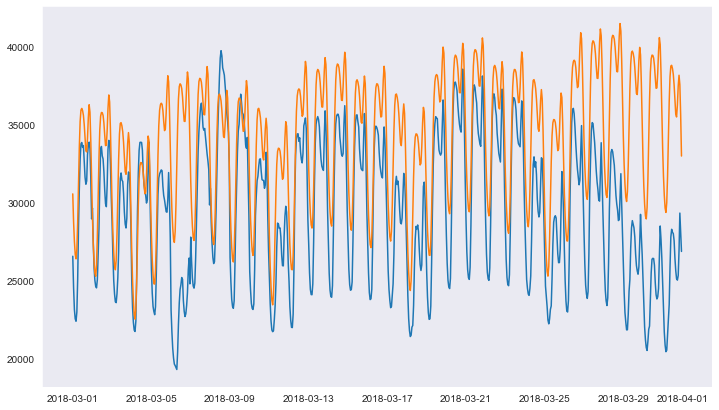

In [134]:
#plot the holidays model forecast

holiday_model_results = forecast_holiday_model.iloc[-len(test):]

def plot_prophet_forecast(actual, predicted):
    
    assert len(actual) == len(predicted), 'Input array length mismach. Check input array lengths are matched.'
        
    #inspect the forecast vs the real values
    fig = plt.figure(figsize=(12,7))

    plt.plot(actual['ds'], actual['y'])
    plt.plot(predicted['ds'], predicted['yhat'])
    
plot_prophet_forecast(test, holiday_model_results)

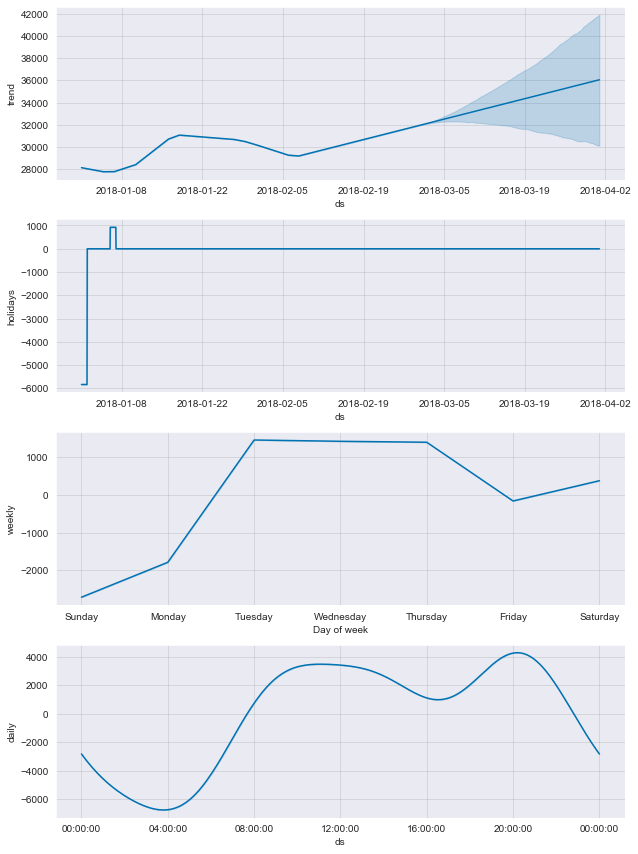

In [135]:
fig = holiday_model.plot_components(forecast_holiday_model)

In [136]:

train.iloc[12000]

ds    2018-05-16 00:00:00
y                   25822
Name: 12000, dtype: object

In [137]:
#run cross validation on the forecast. expanding window per day of the week's forecast

#inital is the size of the training data 31 days * 24 hours = 744 hours
#period is the frequency to make a precition. in this case every day, so every 24 hours
#horizon is the distance in the future to make a prediction. 1 week * 24 hours = 168 hours

cv_holiday_model_base = cross_validation(holiday_model, initial='12000 hours', period='24 hours', horizon='24 hours')

INFO:fbprophet:Making 45 forecasts with cutoffs between 2018-05-16 23:00:00 and 2018-06-29 23:00:00


In [52]:
def disp_prophet_cv_results(crossvalidated):
    
    holiday_model_cv_fig = plot_cross_validation_metric(crossvalidated, metric='mae', rolling_window=0)

    cv_model_results = performance_metrics(crossvalidated)
    
    print('Base model MAE {0:.2f}' .format(np.mean(cv_model_results['mae'])))
    
    #print(cv_model_results)
    
    return cv_model_results

### RESULTS Holiday Model


###### Holiday Model Base
- Holidays only.
- Same as base model
- holiday prior 15
- Train: 2018-01-01 to 2018-02-28
- Test: 2018-03-01 to 2018-03-31


INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-31 23:00:00 and 2018-02-27 23:00:00


Base model MAE 2773.73


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,5.162276e+06,2272.064284,1679.064512,0.069369,0.857143
1,0 days 04:00:00,4.970676e+06,2229.501313,1664.503216,0.071486,0.857143
2,0 days 05:00:00,4.868471e+06,2206.461240,1659.101546,0.072551,0.842217
3,0 days 06:00:00,4.997297e+06,2235.463524,1714.664254,0.074819,0.812367
4,0 days 07:00:00,5.934564e+06,2436.095971,1957.374689,0.081935,0.776652
5,0 days 08:00:00,1.021975e+07,3196.833617,2713.368373,0.103216,0.651386
6,0 days 09:00:00,1.581148e+07,3976.364728,3503.535027,0.124022,0.496269
7,0 days 10:00:00,1.813653e+07,4258.700483,3764.690703,0.125951,0.455224
8,0 days 11:00:00,1.688611e+07,4109.270705,3534.896669,0.112590,0.512260
9,0 days 12:00:00,1.496043e+07,3867.871805,3255.155466,0.100157,0.574627


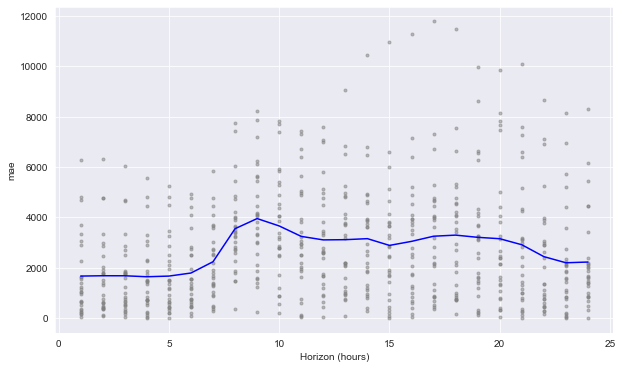

In [143]:
#run cross validator
cv_holiday_model_base = cross_validation(holiday_model, initial='30 days', period='24 hours', horizon='24 hours')

#the results below are for the holiday_model variant 1
disp_prophet_cv_results(cv_holiday_model_base)

###### Holiday Model Low Prior
- Holidays only.
- Same as base model
- holiday prior 05
- Train: 2018-01-01 to 2018-02-28
- Test: 2018-03-01 to 2018-03-31

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-31 23:00:00 and 2018-02-27 23:00:00


Base model MAE 2772.70


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,5.106586e+06,2259.775634,1675.930574,0.069294,0.845416
1,0 days 04:00:00,4.914310e+06,2216.824294,1664.917489,0.071559,0.872068
2,0 days 05:00:00,4.813205e+06,2193.901700,1665.369982,0.072862,0.886994
3,0 days 06:00:00,4.942022e+06,2223.065796,1718.121487,0.074990,0.877932
4,0 days 07:00:00,5.872356e+06,2423.294494,1955.692735,0.081867,0.818230
5,0 days 08:00:00,1.013383e+07,3183.367536,2707.023889,0.102974,0.663113
6,0 days 09:00:00,1.569568e+07,3961.777953,3494.414371,0.123699,0.481343
7,0 days 10:00:00,1.800629e+07,4243.381884,3754.357465,0.125604,0.425373
8,0 days 11:00:00,1.676111e+07,4094.033938,3526.978941,0.112329,0.476546
9,0 days 12:00:00,1.484839e+07,3853.360578,3251.822208,0.100042,0.568763


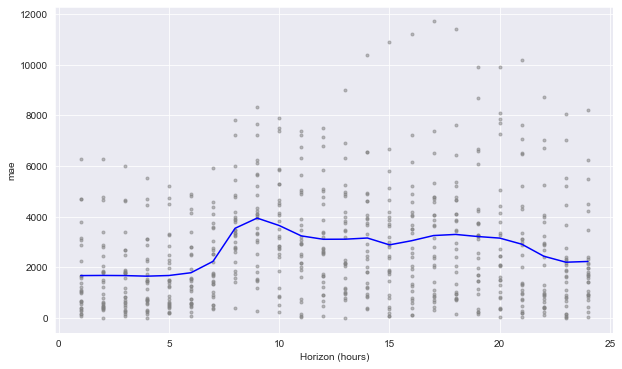

In [145]:
#run cross validator
cv_holiday_model_low_prior = cross_validation(holiday_model, initial='30 days', period='24 hours', horizon='24 hours')

#the results below are for the holiday_model variant 1
disp_prophet_cv_results(cv_holiday_model_low_prior)

###### Holiday Model high prior
- Holidays only.
- Same as base model
- holiday prior 35
- Train: 2018-01-01 to 2018-02-28
- Test: 2018-03-01 to 2018-03-31

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-31 23:00:00 and 2018-02-27 23:00:00


Base model MAE 2757.26


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,5.068121e+06,2251.248751,1670.385104,0.069087,0.851279
1,0 days 04:00:00,4.875890e+06,2208.141737,1657.665041,0.071278,0.842217
2,0 days 05:00:00,4.770386e+06,2184.121372,1656.601315,0.072511,0.842217
3,0 days 06:00:00,4.888163e+06,2210.919149,1705.632588,0.074476,0.851279
4,0 days 07:00:00,5.798475e+06,2408.002383,1939.322348,0.081211,0.812367
5,0 days 08:00:00,1.001728e+07,3165.009180,2692.573605,0.102408,0.663113
6,0 days 09:00:00,1.553203e+07,3941.070066,3483.230656,0.123272,0.511194
7,0 days 10:00:00,1.781814e+07,4221.153392,3744.195669,0.125231,0.470149
8,0 days 11:00:00,1.657521e+07,4071.266581,3513.995764,0.111888,0.518124
9,0 days 12:00:00,1.467875e+07,3831.285035,3235.026626,0.099500,0.574627


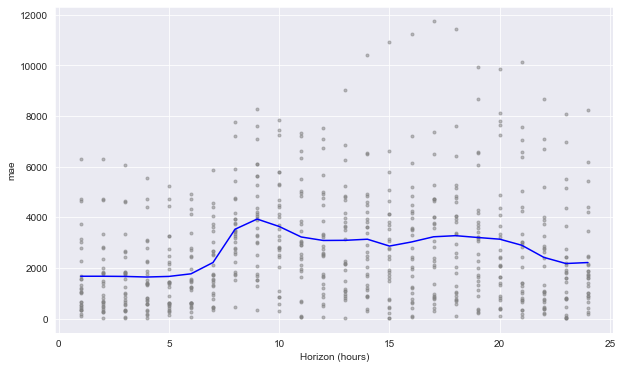

In [147]:
#run cross validator
cv_holiday_model_high_prior = cross_validation(holiday_model, initial='30 days', period='24 hours', horizon='24 hours')

#the results below are for the holiday_model variant 1
disp_prophet_cv_results(cv_holiday_model_high_prior)

###### Short run CV

Regressors:
- days of the week
- holidays

Train: 2018-01-01 to 2018-02-28
Test: 2018-03-01 to 2018-03-31


INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-31 23:00:00 and 2018-02-27 23:00:00


Base model MAE 2841.70


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,6.341942e+06,2518.321230,1823.011639,0.075123,0.836354
1,0 days 04:00:00,6.048628e+06,2459.395905,1812.053046,0.077685,0.851279
2,0 days 05:00:00,5.890100e+06,2426.952825,1828.174108,0.079797,0.857143
3,0 days 06:00:00,5.976697e+06,2444.728349,1892.366374,0.082425,0.842217
4,0 days 07:00:00,6.879283e+06,2622.838695,2101.057843,0.087953,0.812367
5,0 days 08:00:00,1.113546e+07,3336.983963,2819.483862,0.107451,0.642324
6,0 days 09:00:00,1.673921e+07,4091.357923,3588.097823,0.127201,0.472281
7,0 days 10:00:00,1.907495e+07,4367.488036,3836.003655,0.128470,0.428571
8,0 days 11:00:00,1.780012e+07,4219.019123,3613.601674,0.115111,0.482409
9,0 days 12:00:00,1.581618e+07,3976.956216,3343.891560,0.102827,0.553838


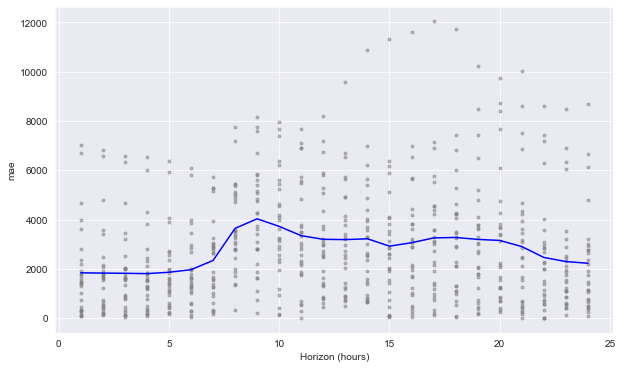

In [123]:
#run the cross validation
cv_holiday_model_2018_01_04 = cross_validation(holiday_model, initial='30 days', period='24 hours', horizon='24 hours')

#print out the error results
disp_prophet_cv_results(cv_holiday_model_2018_01_04)

###### Short run CV

Regressors:
- days of the week
- holidays

Train: 2018-01-01 to 2018-02-28
Test: 2018-03-01 to 2018-03-3

In [ ]:
#run the cross validation
cv_no_holiday_model_2018_01_04 = cross_validation(holiday_model, initial='30 days', period='24 hours', horizon='24 hours')

#print out the error results
disp_prophet_cv_results(cv_no_holiday_model_2018_01_04)

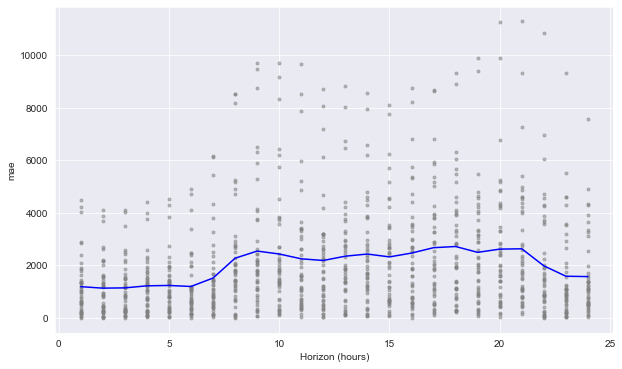

In [141]:
#plot the hourly mean absolute error across all the cross validation examples. 
holiday_model_cv_fig = plot_cross_validation_metric(cv_base_model, metric='mae', rolling_window=0)

In [140]:
#print out the models performance metrics
cv_base_model_metrics = performance_metrics(cv_base_model)

print('Base model MAE {0:.2f}' .format(np.mean(cv_base_model_metrics['mae'])))

cv_base_model_metrics

Base model MAE 2071.90


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,2.402709e+06,1550.067487,1149.686514,0.046828,0.933333
1,0 days 04:00:00,2.431230e+06,1559.240351,1177.037054,0.049946,0.933333
2,0 days 05:00:00,2.537214e+06,1592.863362,1217.217922,0.052741,0.933333
3,0 days 06:00:00,2.679927e+06,1637.048180,1219.874568,0.053069,0.924074
4,0 days 07:00:00,3.519611e+06,1876.062616,1339.461861,0.057014,0.905556
5,0 days 08:00:00,6.341036e+06,2518.141415,1780.905546,0.072724,0.874074
6,0 days 09:00:00,9.842772e+06,3137.319206,2262.094588,0.088195,0.814815
7,0 days 10:00:00,1.147343e+07,3387.244477,2454.983056,0.090565,0.770370
8,0 days 11:00:00,1.098704e+07,3314.670869,2377.478094,0.082632,0.764815
9,0 days 12:00:00,9.810017e+06,3132.094694,2256.086915,0.074763,0.792593


## Weekdays Model

In [154]:
#holiday model initalize
weekdays_model = Prophet(yearly_seasonality=False, 
                        seasonality_mode='additive')

#add regressors for the day of the week
for day in days_df.columns:
    weekdays_model.add_regressor(day, prior_scale=0.8, mode='additive')

#train the model
weekdays_model.fit(train)

### CV Results Weekdays model

###### Weekdays Model base
- Holidays only.
- Same as base model
- weekdays regressors prior 0.5
- Train: 2018-01-01 to 2018-02-28
- Test: 2018-03-01 to 2018-03-31

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-31 23:00:00 and 2018-02-27 23:00:00


Base model MAE 2695.83


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,5.439217e+06,2332.212839,1712.800538,0.070372,0.857143
1,0 days 04:00:00,5.118826e+06,2262.482233,1661.087710,0.071013,0.857143
2,0 days 05:00:00,4.930907e+06,2220.564669,1658.189657,0.072154,0.857143
3,0 days 06:00:00,5.012033e+06,2238.756929,1706.808137,0.074120,0.857143
4,0 days 07:00:00,5.948409e+06,2438.936104,1937.134117,0.080782,0.842217
5,0 days 08:00:00,1.021515e+07,3196.114765,2664.571006,0.101258,0.692964
6,0 days 09:00:00,1.573699e+07,3966.987540,3426.495551,0.121323,0.522921
7,0 days 10:00:00,1.796707e+07,4238.757701,3667.498826,0.122718,0.455224
8,0 days 11:00:00,1.662243e+07,4077.061924,3454.166712,0.109883,0.533049
9,0 days 12:00:00,1.457030e+07,3817.106586,3193.435025,0.098029,0.628465


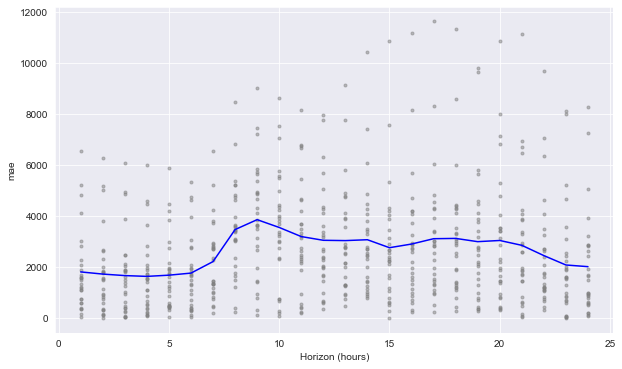

In [149]:
#run the cross validation
cv_weekdays_model_base = cross_validation(weekdays_model, initial='30 days', period='24 hours', horizon='24 hours')

#print out the error results
disp_prophet_cv_results(cv_weekdays_model_base)

###### Weekdays Model low prior
- Holidays only.
- Same as base model
- weekdays regressors prior 0.2
- Train: 2018-01-01 to 2018-02-28
- Test: 2018-03-01 to 2018-03-31

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-31 23:00:00 and 2018-02-27 23:00:00


Base model MAE 2703.67


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,5.454837e+06,2335.559346,1718.840372,0.070592,0.857143
1,0 days 04:00:00,5.139875e+06,2267.129274,1668.001346,0.071279,0.872068
2,0 days 05:00:00,4.957563e+06,2226.558473,1666.303063,0.072475,0.872068
3,0 days 06:00:00,5.044144e+06,2245.917256,1715.613958,0.074471,0.863006
4,0 days 07:00:00,5.990320e+06,2447.513079,1946.651937,0.081152,0.842217
5,0 days 08:00:00,1.027732e+07,3205.826203,2673.812833,0.101600,0.707889
6,0 days 09:00:00,1.581845e+07,3977.242055,3435.213274,0.121626,0.537846
7,0 days 10:00:00,1.805338e+07,4248.927121,3676.112694,0.122997,0.476013
8,0 days 11:00:00,1.670210e+07,4086.820562,3462.661106,0.110140,0.547974
9,0 days 12:00:00,1.464377e+07,3826.718559,3201.779087,0.098269,0.634328


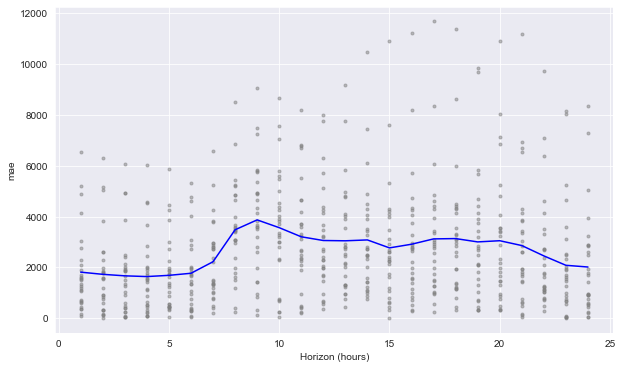

In [153]:
#run the cross validation
cv_weekdays_model_low_wdprior = cross_validation(weekdays_model, initial='30 days', period='24 hours', horizon='24 hours')

#print out the error results
disp_prophet_cv_results(cv_weekdays_model_low_wdprior)

###### Weekdays Model high prior
- Holidays only.
- Same as base model
- weekdays regressors prior 0.8
- Train: 2018-01-01 to 2018-02-28
- Test: 2018-03-01 to 2018-03-31

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-31 23:00:00 and 2018-02-27 23:00:00


Base model MAE 2693.54


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,5.401066e+06,2324.019313,1707.766700,0.070145,0.857143
1,0 days 04:00:00,5.085316e+06,2255.064418,1657.332829,0.070833,0.857143
2,0 days 05:00:00,4.900718e+06,2213.756467,1655.165883,0.072000,0.857143
3,0 days 06:00:00,4.987093e+06,2233.180103,1703.713498,0.073964,0.857143
4,0 days 07:00:00,5.926013e+06,2434.340403,1934.071771,0.080636,0.842217
5,0 days 08:00:00,1.018622e+07,3191.586184,2658.632498,0.101042,0.707889
6,0 days 09:00:00,1.570578e+07,3963.052032,3417.609982,0.121037,0.522921
7,0 days 10:00:00,1.794025e+07,4235.593422,3657.617925,0.122419,0.461087
8,0 days 11:00:00,1.660247e+07,4074.613251,3447.532272,0.109685,0.542111
9,0 days 12:00:00,1.455666e+07,3815.318578,3189.912764,0.097921,0.634328


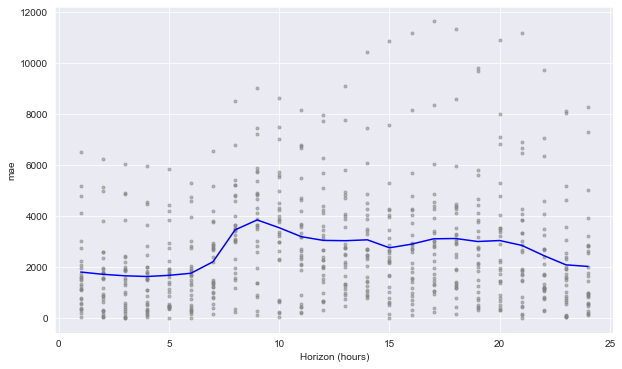

In [155]:
#run the cross validation
cv_weekdays_model_high_wdprior = cross_validation(weekdays_model, initial='30 days', period='24 hours', horizon='24 hours')

#print out the error results
disp_prophet_cv_results(cv_weekdays_model_high_wdprior)

## Model 3: Using Weather Parameters

### Adding temperature, wind, rain, etc to the model

In [4]:
### Import the combined energy and wether data

data_comb = pd.read_csv('./data/cleaned_data/energy_weather_2015_2018.csv', parse_dates=True, index_col='time')
data_comb.head(3)

,actual_load,temp,pressure,wind_speed,rain_1h,rain_3h,snow_3h,heatdd,cooldd
time,,,,,,,,,
2015-01-01 00:00:00,25385.0,271.239327,998.190492,2.078209,0.0,0.0,0.0,19.910673,0.0
2015-01-01 01:00:00,24382.0,271.245271,998.134512,2.078209,0.0,0.0,0.0,19.904729,0.0
2015-01-01 02:00:00,22734.0,270.544537,998.507545,2.230083,0.0,0.0,0.0,20.605463,0.0


Following the data analysis notebook we apply PCA on the weather features to reduce the dimensionality.

Inital CV quick test date ranges. With an inital of 30 days and 28 days cv range.
- start '2018-01-01'
- stop '2018-03-31'
- split 2018-02-28


Full CV dates
- start '2017-01-01'
- stop '2018-03-31'
- split '2017-12-31'
- default regreossor priors = 0.5 unless noted otherwise.

Test perameters:
-start '2018-04-01'
-stop '2018-06-30'


In [5]:
## slice for the date range of previous cv analysis.
#data_comb = data_comb['2018-01-01':'2018-03-31']
data_comb = data_comb['2017-01-01':'2018-06-30']

print(data_comb.index.min(), data_comb.index.max())

data_comb.head(3)

2017-01-01 00:00:00 2018-06-30 23:00:00


,actual_load,temp,pressure,wind_speed,rain_1h,rain_3h,snow_3h,heatdd,cooldd
time,,,,,,,,,
2017-01-01 00:00:00,24401.0,274.912775,1030.016064,1.812104,0.0,0.0,0.0,16.237225,0.0
2017-01-01 01:00:00,23393.0,274.754913,1029.699010,1.740062,0.0,0.0,0.0,16.395087,0.0
2017-01-01 02:00:00,21909.0,273.994245,1028.827032,1.812104,0.0,0.0,0.0,17.155755,0.0


###### Make the pipelines for PCA and MinMaxScaler

In [6]:
## apply PCA pipeline to the weather features.

#initate a min max scaler
minmax = MinMaxScaler()

#initate a PCA object to cpature 90% of dimensionality
pca = PCA(n_components=2)

#initate the pipeline for pca
pca_pipe = make_pipeline(pca, minmax)

minmax_pipe = make_pipeline(minmax)

###### PCA of the weather data

In [7]:
weather_cols = ['temp','pressure','wind_speed','rain_1h','rain_3h','snow_3h','heatdd','cooldd']

#select the weather columns and make sure there are no Nans before transform
data_weather = data_comb[weather_cols].interpolate(method='linear')

#transform the weather data
pca_weather = pca_pipe.fit_transform(data_weather)

#make dataframe with the transformed weather pca
pca_weather_df = pd.DataFrame(pca_weather, index=data_weather.index, columns=['pca1', 'pca2'])

In [6]:
pca_weather_df.head(3)

,pca1,pca2
time,,
2017-01-01 00:00:00,0.111137,0.093135
2017-01-01 01:00:00,0.106763,0.097269
2017-01-01 02:00:00,0.085853,0.108841


###### MinMax Scale of the input predictor

In [8]:
#slice out the energy data
energy_data = data_comb['actual_load']

#apply minmax scaler. reshape because passing Series into function expects 2d array
energy_minmax = minmax_pipe.fit_transform(np.reshape(energy_data.values, (-1,1)))

#convert back to dataframe
energy_minmax_df = pd.DataFrame(energy_minmax, index=energy_data.index, columns=['y'])

energy_minmax_df.head(3)

,y
time,
2017-01-01 00:00:00,0.255879
2017-01-01 01:00:00,0.210731
2017-01-01 02:00:00,0.144265


In [10]:
def standard_index(data):
    data = data.reset_index()
    
    #now that the datetime index is gone be double sure our data is ordered correctly.
    data.sort_values(by=['ds'], inplace=True)
    
    return data

###### Make the train and test sets

In [93]:
def debug(data, split_date):
    """
    Function takes in dataset where rows are daily values and columns are hourly slices and splits into a train and test.
    
    """
    
    data.sort_index(ascending=True, inplace=True)
    
    #set the train data. do this separately because date based slicing does NOT work the same as integer based slicing.
    train = data.loc[:split_date,:]

    split_date = dt.datetime.strptime(split_date, '%Y-%m-%d')
    
    #increment the split date by 1
    split_date += dt.timedelta(days=1)
    
    test = data.loc[split_date:, :]
    
    print(train.index.min(), train.index.max())
    print(test.index.min(), test.index.max())
    
    return train, test

In [94]:
a, b = debug(data_comb, '2018-02-15')

2017-01-01 00:00:00 2018-02-15 23:00:00
2018-02-16 00:00:00 2018-06-30 23:00:00


In [11]:
#combine the energy and weather again as scaled features

data_scaled = pd.concat([energy_minmax_df,pca_weather_df], axis=1)

data_scaled.index.name='ds'

#split in train and test
train_e_w, test_e_w = train_test_split(data_scaled, '2018-03-31')

#change and order index for prophet 
train_e_w = standard_index(train_e_w)

##change and order index for prophet
test_e_w = standard_index(test_e_w)


print('Length of the train dataset {}' .format(len(train_e_w)))
print('Length of the test dataset {}' .format(len(test_e_w)))
train_e_w.head(3)

Train start and stop dates 2017-01-01 00:00:00 2018-03-31 23:00:00
Test start and stop dates 2018-04-01 00:00:00 2018-06-30 23:00:00
Length of the train dataset 10920
Length of the test dataset 2184


,ds,y,pca1,pca2
0,2017-01-01 00:00:00,0.255879,0.111137,0.093135
1,2017-01-01 01:00:00,0.210731,0.106763,0.097269
2,2017-01-01 02:00:00,0.144265,0.085853,0.108841


###### Setup function to process the fit, cross validation, and perormance for each model

In [12]:
def prophet_cv_performance(model, train, pipe):
    
    #fit the model
    model.fit(train)
    
    #run cross validation
    cv_results = cross_validation(model, initial='365 days', period='24 hours', horizon='24 hours')
    
    #inverse transform the target and prediction columns
    cv_results[['yhat', 'y']] = minmax_pipe.inverse_transform(cv_results[['yhat','y']])
    
    #get performance results on the cv output
    cv_performance = performance_metrics(cv_results)
    
    #display the results
    print('Model Mean Hourly MAE {0:.2f}' .format(np.mean(cv_performance['mae'])))
    print('Model Mean Hourly MAPE {0:.2f}' .format(np.mean(cv_performance['mape'])))
    
    return cv_results, cv_performance

## Model Cross Validations

All Cross validation results on the following Train parmaters are presented below.

Cross validation dates (training set):
- start '2017-01-01'
- stop '2018-03-31'
- split '2017-12-31'
- default regreossor priors = 0.5 unless noted otherwise.

Test perameters:
-start '2018-04-01'
-stop '2018-06-30'

Therefore cv parameters are:
- initial='365 days'
- period='24 hours'
- horizon='24 hours

##### Basic model

No additional regressors

/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Making 89 forecasts with cutoffs between 2018-01-01 23:00:00 and 2018-03-30 23:00:00


Model Mean Hourly MAE 2372.95
Model Mean Hourly MAPE 0.08


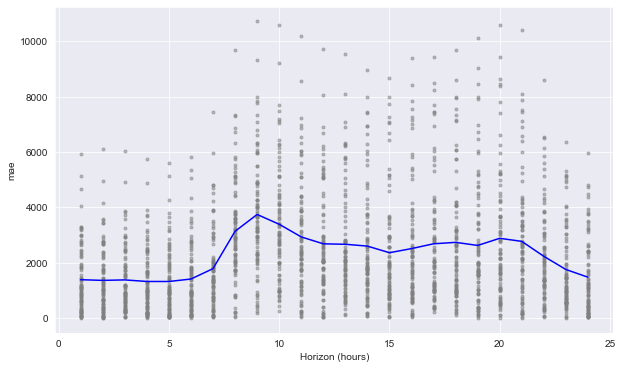

In [14]:
#weather base model initalize
base_model_2017 = Prophet(yearly_seasonality=True, 
                        seasonality_mode='additive')

#fit model, run cross validation, return results, performance, and mean MAE
base_cv_results_2017, base_cv_perfomance_2017 = prophet_cv_performance(base_model_2017, train_e_w, minmax_pipe)

#plot the crossvalidated error performance
plot_cross_validation_metric(base_cv_results_2017, metric='mae', rolling_window=0);

base_cv_results_2017.to_csv('./results/prophet/base_cv_results_2017.csv')
base_cv_perfomance_2017.to_csv('./results/prophet/base_cv_performance_2017.csv')

###### Model with weather PCA regressors

/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Making 89 forecasts with cutoffs between 2018-01-01 23:00:00 and 2018-03-30 23:00:00


Model Mean Hourly MAE 2366.17
Model Mean Hourly MAPE 0.08


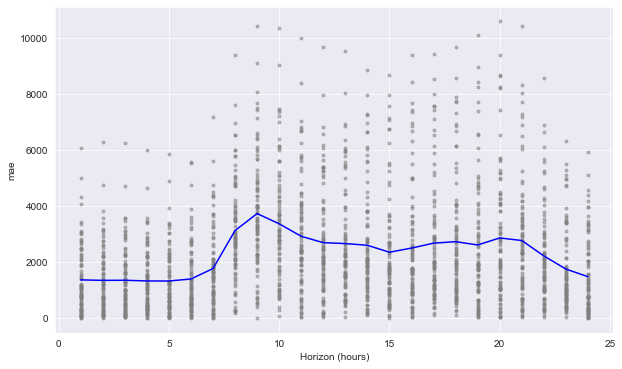

In [16]:
#weather base model initalize
weather_model_2017 = Prophet(yearly_seasonality=True, 
                        seasonality_mode='additive')

#add regressors for the pca weather regressors
weather_model_2017.add_regressor('pca1', prior_scale=0.8, mode='additive')
weather_model_2017.add_regressor('pca2', prior_scale=0.8, mode='additive')

#fit model, run cross validation, return results, performance, and mean MAE
weather_cv_results_2017, weather_cv_perfomance_2017 = prophet_cv_performance(weather_model_2017, train_e_w, minmax_pipe)

#plot the crossvalidated error performance
plot_cross_validation_metric(weather_cv_results, metric='mae', rolling_window=0);

weather_cv_results_2017.to_csv('./results/prophet/weather_cv_results_2017_prior08.csv')
weather_cv_perfomance_2017.to_csv('./results/prophet/weather_cv_performance_2017_prior08.csv')

## Starting with a high prior on weather

prior = 0.8

INFO:fbprophet:Making 92 forecasts with cutoffs between 2017-09-30 23:00:00 and 2017-12-30 23:00:00


Model Mean Hourly MAE 2542.25
Model Mean Hourly MAPE 0.09


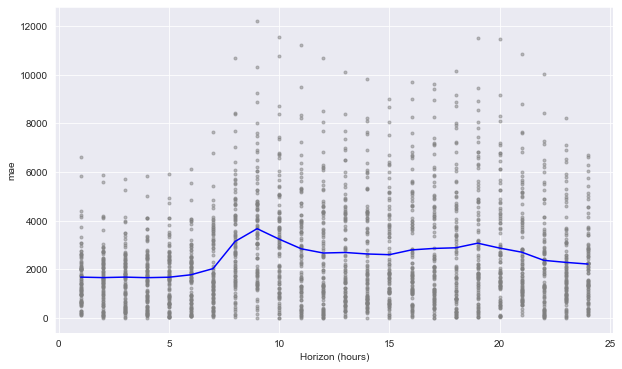

In [53]:
#weather base model initalize
weather_model_2017_high = Prophet(yearly_seasonality=True, 
                        seasonality_mode='additive')

#add regressors for the pca weather regressors
weather_model_2017_high.add_regressor('pca1', prior_scale=0.8, mode='additive')
weather_model_2017_high.add_regressor('pca2', prior_scale=0.8, mode='additive')

#fit model, run cross validation, return results, performance, and mean MAE
weather_cv_results_2017high, weather_cv_perfomance_2017high = prophet_cv_performance(weather_model_2017_high, train_e_w, minmax_pipe)

#plot the crossvalidated error performance
plot_cross_validation_metric(weather_cv_results_2017high, metric='mae', rolling_window=0);

## Starting with a low prior on weather

/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Making 92 forecasts with cutoffs between 2017-09-30 23:00:00 and 2017-12-30 23:00:00


Model Mean Hourly MAE 2537.54
Model Mean Hourly MAPE 0.09


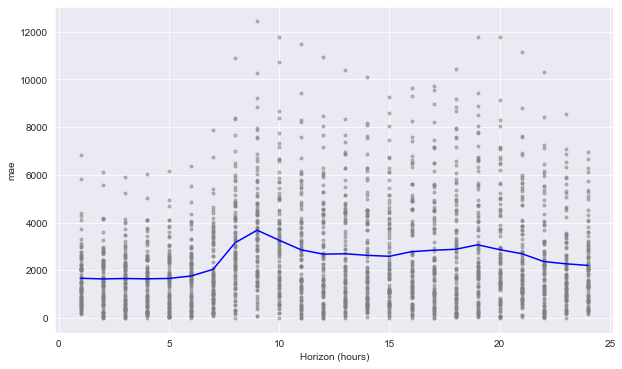

In [55]:
#weather base model initalize
weather_model_2017_low = Prophet(yearly_seasonality=True, 
                        seasonality_mode='additive')

#add regressors for the pca weather regressors
weather_model_2017_low.add_regressor('pca1', prior_scale=0.2, mode='additive')
weather_model_2017_low.add_regressor('pca2', prior_scale=0.2, mode='additive')

#fit model, run cross validation, return results, performance, and mean MAE
weather_cv_results_2017low, weather_cv_perfomance_2017low = prophet_cv_performance(weather_model_2017_low, train_e_w, minmax_pipe)

#plot the crossvalidated error performance
plot_cross_validation_metric(weather_cv_results_2017low, metric='mae', rolling_window=0);

INFO:fbprophet:Making 28 forecasts with cutoffs between 2018-01-31 23:00:00 and 2018-02-27 23:00:00
/Users/ns/anaconda3/envs/bk_py3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Base model MAE 0.13


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,0.009892,0.099457,0.072098,0.405439,0.907783
1,0 days 04:00:00,0.009201,0.095922,0.070093,0.578847,0.922708
2,0 days 05:00:00,0.008772,0.093657,0.069468,0.716662,0.913646
3,0 days 06:00:00,0.008952,0.094617,0.070743,0.649938,0.898721
4,0 days 07:00:00,0.011297,0.106289,0.083596,0.497341,0.892857
5,0 days 08:00:00,0.022180,0.148930,0.124652,0.439773,0.743603
6,0 days 09:00:00,0.035383,0.188104,0.165175,0.447354,0.549574
7,0 days 10:00:00,0.040362,0.200903,0.177406,0.398694,0.476013
8,0 days 11:00:00,0.037077,0.192555,0.166021,0.312219,0.533049
9,0 days 12:00:00,0.032151,0.179308,0.151857,0.249973,0.619403


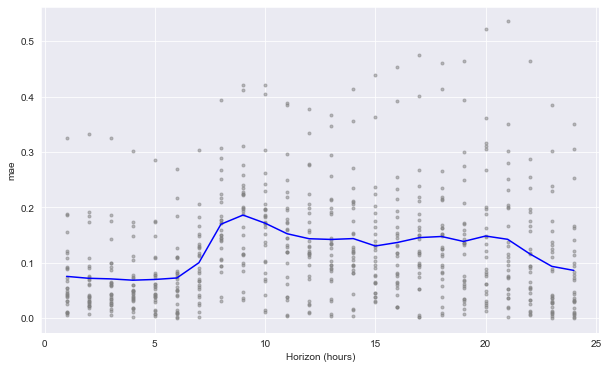

In [83]:
#run cross validator
weather_model_base = cross_validation(weather_model, initial='30 days', period='24 hours', horizon='24 hours')

#the results below are for the holiday_model variant 1
disp_prophet_cv_results(weather_model_base)

In [ ]:
### Need to inverse transform inorder to compare


In [95]:
weather_model_base

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-02-01 00:00:00,6.220345e+08,0.348564,0.674551,477356364.0,2018-01-31 23:00:00
1,2018-02-01 01:00:00,5.866048e+08,0.276183,0.598761,438612312.0,2018-01-31 23:00:00
2,2018-02-01 02:00:00,5.603633e+08,0.215303,0.538500,415922076.0,2018-01-31 23:00:00
3,2018-02-01 03:00:00,5.404323e+08,0.160498,0.504698,406125456.0,2018-01-31 23:00:00
4,2018-02-01 04:00:00,5.311608e+08,0.144555,0.465382,404355744.0,2018-01-31 23:00:00
...,...,...,...,...,...,...
667,2018-02-28 19:00:00,7.657014e+08,0.674227,0.986988,787371984.0,2018-02-27 23:00:00
668,2018-02-28 20:00:00,7.799096e+08,0.712218,1.031422,803278324.0,2018-02-27 23:00:00
669,2018-02-28 21:00:00,7.683733e+08,0.675056,1.003659,782821296.0,2018-02-27 23:00:00
670,2018-02-28 22:00:00,7.297334e+08,0.592862,0.929296,726085172.0,2018-02-27 23:00:00


In [86]:
y_yhat = weather_model_base[['y','yhat']].copy()
print(y_yhat)

inv_y_yhat = minmax_pipe.inverse_transform(y_yhat)

y_yhat = weather_model_base

y_yhat[['y','yhat']] = inv_y_yhat.copy()

y_yhat_performance = performance_metrics(y_yhat)

           y          yhat
0    22657.0  29524.199969
1    20818.0  27842.516827
2    19741.0  26596.952573
3    19276.0  25650.920525
4    19192.0  25210.845182
..       ...           ...
667  37372.0  36343.396165
668  38127.0  37017.795938
669  37156.0  36470.219825
670  34463.0  34636.166083
671  31216.0  30534.533598

[672 rows x 2 columns]


In [87]:

    
print('Base model MAE {0:.2f}' .format(np.mean(y_yhat_performance['mae'])))
y_yhat_performance

Base model MAE 55792335.94


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,1.948778e+15,4.414497e+07,3.200134e+07,0.063327,0.0
1,0 days 04:00:00,1.812705e+15,4.257587e+07,3.111169e+07,0.064093,0.0
2,0 days 05:00:00,1.728122e+15,4.157069e+07,3.083406e+07,0.064694,0.0
3,0 days 06:00:00,1.763712e+15,4.199657e+07,3.140020e+07,0.065648,0.0
4,0 days 07:00:00,2.225722e+15,4.717756e+07,3.710490e+07,0.073894,0.0
5,0 days 08:00:00,4.369751e+15,6.610409e+07,5.532820e+07,0.099162,0.0
6,0 days 09:00:00,6.970907e+15,8.349196e+07,7.331466e+07,0.122350,0.0
7,0 days 10:00:00,7.951792e+15,8.917282e+07,7.874371e+07,0.124390,0.0
8,0 days 11:00:00,7.304675e+15,8.546739e+07,7.369012e+07,0.110926,0.0
9,0 days 12:00:00,6.334231e+15,7.958788e+07,6.740319e+07,0.098097,0.0


In [65]:
forecast_base_model = base_model.predict(test)
forecast_base_model.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-02 00:00:00,27015.192395,20884.359735,27452.146728,27015.192395,27015.192395,-2835.032727,-2835.032727,-2835.032727,-2752.975813,-2752.975813,-2752.975813,-82.056913,-82.056913,-82.056913,0.0,0.0,0.0,24180.159668
1,2017-01-02 01:00:00,27019.869316,18965.364516,25837.867917,27019.869316,27019.869316,-4375.074919,-4375.074919,-4375.074919,-4470.314771,-4470.314771,-4470.314771,95.239853,95.239853,95.239853,0.0,0.0,0.0,22644.794398


In [114]:
forecast_base_model.tail(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2110,2017-03-31 22:00:00,26024.409003,17812.713388,39948.853266,15372.780713,37091.495610,2522.457146,2522.457146,2522.457146,2014.061163,2014.061163,2014.061163,508.395983,508.395983,508.395983,0.0,0.0,0.0,28546.866148
2111,2017-03-31 23:00:00,26020.949714,14934.805545,37563.643659,15354.122623,37112.003355,-78.493165,-78.493165,-78.493165,-452.724952,-452.724952,-452.724952,374.231787,374.231787,374.231787,0.0,0.0,0.0,25942.456549


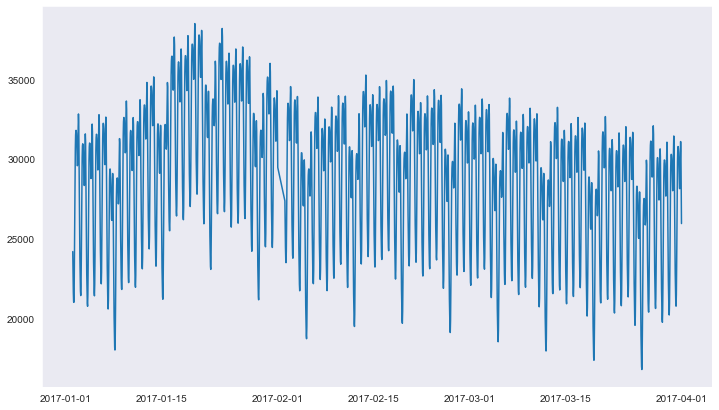

In [113]:
#inspect the forecast vs the real values
fig = plt.figure(figsize=(12,7))


#plt.plot(test['actual_load'])
#plt.plot(test['ds'], test['y'])
plt.plot(forecast_base_model['ds'], forecast_base_model['yhat'])

#fig1 = base_model.plot(forecast_base_model, uncertainty=False)

In [31]:
#make the future dataframe. a df of 7 days with hourly intervals
future = base_model.make_future_dataframe(periods=24*7, freq='h')

In [32]:
#forecast the future week
forecast = base_model.predict(future)

In [38]:
#run cross validation on the forecast. expanding window per day of the week's forecast

#inital is the size of the training data 31 days * 24 hours = 744 hours
#period is the frequency to make a precition. in this case every day, so every 24 hours
#horizon is the distance in the future to make a prediction. 1 week * 24 hours = 168 hours
cv_base_model = cross_validation(base_model, initial='20 days',period='24 hours', horizon='24 hours')

INFO:fbprophet:Making 10 forecasts with cutoffs between 2017-01-21 23:00:00 and 2017-01-30 23:00:00


##### Plot of hourly errors from walk forward validation

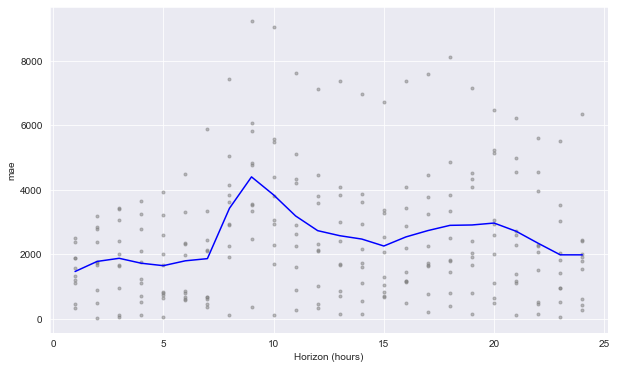

In [51]:
#plot the hourly mean absolute error across all the cross validation examples. 
base_model_cv_fig = plot_cross_validation_metric(cv_base_model, metric='mae', rolling_window=0)

In [120]:
#print out the models performance metrics
cv_base_model_metrics = performance_metrics(cv_base_model)

print('Base model MAE {0:.2f}' .format(np.mean(cv_base_model_metrics['mae'])))

cv_base_model_metrics

Base model MAE 2572.62


,horizon,mse,rmse,mae,mape,coverage
0,0 days 03:00:00,4.204557e+06,2050.501746,1763.435656,0.068792,1.000000
1,0 days 04:00:00,4.499592e+06,2121.224243,1792.353308,0.072917,1.000000
2,0 days 05:00:00,4.317587e+06,2077.880386,1713.258811,0.071398,1.000000
3,0 days 06:00:00,4.454910e+06,2110.665692,1719.011947,0.071865,0.958333
4,0 days 07:00:00,5.303467e+06,2302.925836,1797.319185,0.073612,0.916667
5,0 days 08:00:00,9.722319e+06,3118.063287,2501.021475,0.093617,0.775000
6,0 days 09:00:00,1.753156e+07,4187.070417,3568.928722,0.123347,0.608333
7,0 days 10:00:00,2.115904e+07,4599.895216,4002.791723,0.131376,0.516667
8,0 days 11:00:00,1.855525e+07,4307.580692,3660.211699,0.114275,0.541667
9,0 days 12:00:00,1.414734e+07,3761.294723,3104.747824,0.093213,0.625000
